In [1]:
import astropy.units as u
import numpy as np
import popsims
import matplotlib.pyplot as plt
import astropy.coordinates as astro_coord
import glob
import pandas as pd

import itertools
from scipy import stats

from popsims.plot_style import  plot_style
plot_style()

#from shapey import Box
#paths
path_plot ='../figures/'
path_data = '../data/stream/'
isochrone_path='../data/isochrones/'
path_pipeline= '../data/pipelineWithMetCuts/'

import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
import matplotlib as mpl
from scipy.interpolate import UnivariateSpline
from popsims.plot_tools import plot_annotated_heatmap
from matplotlib import patches
from easyshapey import Box

#plt.style.use('dark_background')

In [2]:
#SOME CONSTANTS

dgrid=np.arange(0.5, 10, 0.1)
BEST_BW=0.6
BEST_BW_RANGE=[0.6, 0.9]

#THEORITICAL_STREAM_WIDTHS={'10_20': 0.053, '30_40': 0.094, '50_60':0.127}
THEORITICAL_STREAM_WIDTHS={'10_20': 0.2, '30_40': 0.3, '50_60':0.5}
GAP_SIZES={'10_20': 1.4, '30_40': 1.8, '50_60': 1.8} #trying sum

GAP_PERCENTILE=95

PATH_POLYNOMIALS = np.load('../data/polynomial_stream_paths.npy', allow_pickle=True).flatten()[0]

FMTS={'10_20': 'o', '30_40': '*', '50_60': '^'}

In [3]:
def make_box(center, xextent, yextent):
    b=Box()
    x_min, x_max =center[0]- xextent/2, center[0]+ xextent/2
    y_min, y_max =center[-1]- yextent/2, center[-1]+ yextent/2
    v1= (x_min, y_min)
    v2=(x_min, y_max)
    v4= (x_max, y_min)
    v3=(x_max,y_max)

    b.vertices=[v1, v2, v3, v4, v1]
    return b

In [4]:
def make_line_plot(ax, x, y, yerr, rgc, show_error=False, **kwargs):
    
    nans=np.logical_or.reduce([np.isnan(x), np.isnan(y), np.isnan(yerr)])
    #print (vls)
    rgcx=int(np.nanmedian(np.array(rgc.split('_')).astype(float)))
    
    y1 = np.interp(dgrid, x, y) 
    dy1 = np.interp(dgrid, x, y-yerr)
    dy2 = np.interp(dgrid, x, y+yerr)
    
    ax.plot(dgrid, y1, **kwargs)
    
    if show_error:
        ax.fill_between(dgrid, dy1, dy2, alpha=0.1, color=colors[rgc])

In [5]:
def get_counts(df, dgrid, rgc, m):
    
    rgcx=int(np.nanmedian(np.array(rgc.split('_')).astype(float)))
    
    bools=np.logical_and.reduce([(df.bw >=BEST_BW_RANGE[0]).values,\
                                 (df.bw <=BEST_BW_RANGE[1]).values,\
                                 (df.rgc==rgc).values,
                                 (df.mag_limit==m).values])
    
    #bckd=read_backgrounds_file(m, rgc)
    #bckd['distance']=10**((bckd.dmod.values/5)+1)
    
    #print (bools)
    df0=(df[bools]).reset_index(drop=True)
    #jkl
    res={'gap_dens':[],
         'stream_dens':[],
         'bck_dens':[],
         'gap_stream_ratio':[],
         'stream_bck_ratio':[],
         'gap_bck_ratio':[],
         'st_error_percent':[],
         'gp_error_percent':[],
         'bck_error_percent':[],
         'gp_snr':[],
         'str_snr':[],
         'gap_spread':[],
         'median_gaploc':[],
         'median_treamloc':[],
         'gp_minus_bck_str_minus_bck':[],
         'gp_minus_bck':[],
         'std_gaploc':[],
         'med_gaploc':[],
         'std_streamloc':[],
         'fr_out_gap':[],
         'fr_stars_out_gap':[],
         'std_gaploc_gapsize_ratio':[],
         'med_gaploc_gapsize_ratio':[],
         'gap_area_over_true_area':[],
         'range_gaploc_gapsize_ratio':[],
         'gp_minus_bck_bck_ratio':[],
         'gp_minus_st_st_ratio':[],
         'ds': dgrid}
    
    for idx in range(len(dgrid)-1):
        v=df0[np.logical_and(df0.distance/1e6>=dgrid[idx], df0.distance/1e6<dgrid[idx+1])]
        
        #vbck=bckd[np.logical_and(bckd.distance/1e6>=dgrid[idx], bckd.distance/1e6<dgrid[idx+1])]
        
        st, st_err=  np.nanmedian(v.stream_dens.values),  np.nanstd(v.stream_dens.values)
        gp, gp_err=  np.nanmedian(v.gap_dens.values),  np.nanstd(v.gap_dens.values)
        #bck, bck_err=  np.nanmedian(vbck.density.values), np.nanstd(vbck.density.values)
        bck, bck_err=np.nanmedian(v.bck_dens.values), np.nanstd(v.bck_dens.values)
        
        #densities
        res['stream_dens'].append([st, st_err])
        res['gap_dens'].append([gp, gp_err])
        res['bck_dens'].append([bck, bck_err])

        stream_bck_ratio=st/bck
        gap_bck_ratio= gp/bck
        gap_st_ratio= gp/st
        #errors
        stream_bck_ratio_er= ((st_err/st)**2+ (bck_err/bck)**2)**0.5
        gap_bck_ratio_er= ((gp_err/gp)**2+ (bck_err/bck)**2)**0.5
        gap_st_ratio_er= ((gp_err/gp)**2+ (st_err/st)**2)**0.5
        
        res['gap_stream_ratio'].append([gap_st_ratio,gap_st_ratio_er])
        res['gap_bck_ratio'].append([gap_bck_ratio,gap_bck_ratio_er])
        res['stream_bck_ratio'].append([stream_bck_ratio,stream_bck_ratio_er])
        
        res['gp_minus_bck_bck_ratio'].append([(gp-bck)/st, 0])
        res['gp_minus_st_st_ratio'].append([(gp-st)/st, 0])

        
    
        res['st_error_percent'].append([st_err/st, 0.])
        res['gp_error_percent'].append([gp_err/gp, 0])
        res['bck_error_percent'].append([bck_err/bck, 0])
        
        res['gp_minus_bck_str_minus_bck'].append([(gp-bck)/(st-bck), 0])
        res['gp_minus_bck'].append([gp-bck, 0])
        
        
        gap_area= np.nanmedian(v.gap_area.values)
        gap_area_err= np.nanstd(v.gap_area.values)
        
        true_gap_area= GAP_SIZES[rgc]*0.2#np.nanmedian(v.spread_stream_stars_y.values)
        res['gap_area_over_true_area'].append([gap_area/true_gap_area,  gap_area_err/true_gap_area])
        cs= v.gap_points.values
    
        csx=[]
        
        if len(cs)>0:
            csx=np.concatenate([x for x in cs if len(x)>0])
    
            diffs=np.abs(csx-rgcx)
            med= np.nanmedian(diffs)
            std=np.nanstd(diffs)
            rang= np.ptp(diffs)
            
            fr= len(diffs[np.abs(diffs>0.5*GAP_SIZES[rgc])])/len(diffs)
            
            res['fr_out_gap'].append([fr, 0])
            res['std_gaploc_gapsize_ratio'].append([std/GAP_SIZES[rgc], 0])
            res['med_gaploc_gapsize_ratio'].append([med/GAP_SIZES[rgc], 0])
            res['range_gaploc_gapsize_ratio'].append([rang//GAP_SIZES[rgc], 0])
            res['std_gaploc'].append([std, 0])
            res['med_gaploc'].append([med, 0])
        else:
            res['fr_out_gap'].append([np.nan, 0])
            res['std_gaploc_gapsize_ratio'].append([np.nan, 0])
            res['med_gaploc_gapsize_ratio'].append([np.nan, 0])
            res['range_gaploc_gapsize_ratio'].append([np.nan, 0])
            res['std_gaploc'].append([np.nan, 0])
            res['med_gaploc'].append([np.nan, 0])
            
        
        cs= v.gap_stars.values
        csx=[]
        if len(cs)>0:
            csx=np.concatenate([x for x in cs if len(x)>0])
    
            diffs=np.abs(csx-rgcx)
            med= np.nanmedian(diffs)
            std=np.nanstd(diffs)
            rang= np.ptp(diffs)
            
            fr= len(diffs[np.abs(diffs>0.5*GAP_SIZES[rgc])])/len(diffs)
            
            res['fr_stars_out_gap'].append([fr, 0])
        else:
            res['fr_stars_out_gap'].append([np.nan, 0])
            

    return res

In [6]:
def plot():
            if plot=='show_mask_data':
                ax.scatter(data_df.x, data_df.y,  s=ms, alpha=alpha, c='k')
                ax.scatter(data_df.x[stream_track_on_data], data_df.y[stream_track_on_data],  s=10, alpha=0.1, c='r', label='Stream')
                ax.scatter(data_df.x[gap_track_on_data], data_df.y[gap_track_on_data],  s=10, alpha=0.1, c='b', label='Gap')

            if plot=='show_mask_grid':
                ax.scatter(grid_df.x, grid_df.y,  s=ms, alpha=alpha, c='k')
                ax.scatter(grid_df.x[stream_track], grid_df.y[stream_track],  s=10, alpha=1, c='r', label='Stream')
                ax.scatter(grid_df.x[gap_track], grid_df.y[gap_track],  s=10, alpha=1, c='b', label='Gap')
                #ax.scatter(grid_df.x[stream_track], grid_df.y,  s=10, alpha=0.1, c='b', label='Bckgd')

            if plot=='show_gap_points':
                #ax.scatter(grid_df.x, grid_df.y,  s=ms, alpha=alpha, c='k')
                #ax.scatter(grid_df.x[stream_track], grid_df.y[stream_track],  s=10, alpha=1, c='r', label='Stream')
                ax.scatter(grid_data[:,0][gap_track],grid_data[:,1][gap_track],  s=ms, alpha=alpha, c='#01FF70', marker='*')
                #ax.scatter(grid_df.x[stream_track], grid_df.y,  s=10, alpha=0.1, c='b', label='Bckgd')

            if plot=='plot0':
                #verify by plotting
                ax.scatter(vld['data'][0], vld['data'][1],s=10, alpha=alpha, c='k')

            if plot=='plot1':

                p= ax.contour(vld['meshgrid'][0], vld['meshgrid'][1],  vld['density'],  20, \
                                  cmap='Greys', alpha=.2, linestyle='--')
                ax.contourf(vld['meshgrid'][0], vld['meshgrid'][1],  vld['max_eigen'],  20, \
                                  cmap='magma_r', alpha=1)
                #ax.scatter(grid_data[:,0], grid_data[:,1], c=res['max_eigen'].flatten(),
                #           s=1, cmap='cubehelix')

            if plot=='plot2':

                ax.contourf(vld['meshgrid'][0], vld['meshgrid'][1],  vld['min_eigen'],  20, \
                                  cmap='cubehelix', alpha=1)
                p= ax.contour(vld['meshgrid'][0], vld['meshgrid'][1],  vld['density'],  20, \
                                  cmap='Greys', alpha=.2, linestyle='--')

            if plot=='plot6':
                #ax.scatter(vld['data'][:,0], vld['data'][:,1],s=0.1, alpha=0.5, c='k')
                ax.contourf(vld['meshgrid'][0], vld['meshgrid'][1],  vld['max_eigen'],  20, \
                                  cmap='magma_r', alpha=alpha, vmin=0, vmax=1)
                p= ax.contour(vld['meshgrid'][0], vld['meshgrid'][1],  vld['density'],  20, \
                                                cmap='Greys', alpha=1, vmin=0.0, vmax=0.2, linestyle='--')



            if plot=='plot4':
                #verify by plotting
                #ax.scatter(vld['data'][0], vld['data'][1],s=ms, alpha=alpha,  c='#FFFFFF')
                #ax.scatter(meshgrid[0][stream_mask], meshgrid[1][stream_mask], marker='*', s=15,c='#FF851B')
                ax.scatter(meshgrid[0][gap_mask], meshgrid[1][gap_mask], marker='*', s=15,  c='#0074D9')

                #p= ax.contour(vld['meshgrid'][0], vld['meshgrid'][1],  vld['max_eigen'],  20, color='b', alpha=0.5)

                #plot stream track
                ax.plot(vld['meshgrid'][0], pol(vld['meshgrid'][0])+stream_size/2, c='#FF851B', linewidth=3)
                ax.plot(vld['meshgrid'][0], pol(vld['meshgrid'][0])-stream_size/2, c='#FF851B', linewidth=3)

                #plot gap track
                ax.vlines(x=grid_data[:,0][gap_track].min(), \
                           ymin=pol(grid_data[:,0][gap_track].min())-stream_size/2,
                           ymax=pol(grid_data[:,0][gap_track].min())+stream_size/2, color='#0074D9', linewidth=3)
                ax.vlines(x=grid_data[:,0][gap_track].max(), \
                           ymin=pol(grid_data[:,0][gap_track].max())-stream_size/2,
                           ymax=pol(grid_data[:,0][gap_track].max())+stream_size/2, color='#0074D9', linewidth=3)
                #limit
                ax.set(xlim=[np.min(vld['data'][0]), np.max(vld['data'][0])],\
                       ylim=[np.min(vld['data'][1]), np.max(vld['data'][1])])

            if plot=='plot3':
                #verify by plotting
                #ax.scatter(vld['data'][:,0], vld['data'][:,1], s=10, alpha=alpha, c='k')
                #p= ax.contour(vld['meshgrid'][0], vld['meshgrid'][1],  vld['max_eigen'],  20, color='b', alpha=0.5)

                #plot stream track
                ax.plot(vld['meshgrid'][0], pol(vld['meshgrid'][0])+stream_size/2, color='#FF851B', linewidth=3, alpha=alpha)
                ax.plot(vld['meshgrid'][0], pol(vld['meshgrid'][0])-stream_size/2, c='#FF851B', linewidth=3, alpha=alpha)

                #plot gap track
                ax.vlines(x=grid_data[:,0][gap_track].min(), \
                           ymin=pol(grid_data[:,0][gap_track].min())-stream_size/2,
                           ymax=pol(grid_data[:,0][gap_track].min())+stream_size/2, color='#FF851B', linewidth=3)
                ax.vlines(x=grid_data[:,0][gap_track].max(), \
                           ymin=pol(grid_data[:,0][gap_track].max())-stream_size/2,
                           ymax=pol(grid_data[:,0][gap_track].max())+stream_size/2, color='#FF851B', linewidth=3)
                #limit
                ax.set(xlim=[np.min(vld['data'][0]), np.max(vld['data'][0])],\
                       ylim=[np.min(vld['data'][1]), np.max(vld['data'][1])])

            if plot=='plot7':
                p= ax.contour(vld['meshgrid'][0], vld['meshgrid'][1],  vld['density'],  20, \
                                  cmap='Greys', alpha=alpha*3, linestyle='--')
                #plot stream track
                ax.plot(vld['meshgrid'][0], pol(vld['meshgrid'][0])+stream_size/2, color='#FF851B', linewidth=3, alpha=alpha)
                ax.plot(vld['meshgrid'][0], pol(vld['meshgrid'][0])-stream_size/2, c='#FF851B', linewidth=3, alpha=alpha)

                #plot gap track
                ax.scatter(np.nanmedian(grid_data[:,0][gap_track]), \
                           np.nanmax(vld['meshgrid'][1])-0.5, color='k', marker='$\u2193$', s=100)
                #ax.vlines(x=grid_data[:,0][gap_track].min(), \
                #           ymin=pol(grid_data[:,0][gap_track].min())-stream_size/2,
                #           ymax=pol(grid_data[:,0][gap_track].min())+stream_size/2, color='#FF851B', linewidth=3)
                #ax.vlines(x=grid_data[:,0][gap_track].max(), \
                #           ymin=pol(grid_data[:,0][gap_track].max())-stream_size/2,
                #           ymax=pol(grid_data[:,0][gap_track].max())+stream_size/2, color='#FF851B', linewidth=3)
                #limit
                ax.set(xlim=[np.min(vld['data'][0]), np.max(vld['data'][0])],\
                       ylim=[np.min(vld['data'][1]), np.max(vld['data'][1])])



            if plot=='plot5':
                #verify by plotting
                #ax.scatter(vld['data'][0], vld['data'][1], s=10, alpha=0.2, c='k')
                p= ax.contour(vld['meshgrid'][0], vld['meshgrid'][1],  vld['max_eigen'],  20, cmap='magma_r', alpha=0.5)

                #plot stream track
                #ax.plot(vld['meshgrid'][0], pol(vld['meshgrid'][0])+stream_size/2, c='#0074D9', linewidth=3)
                #ax.plot(vld['meshgrid'][0], pol(vld['meshgrid'][0])-stream_size/2, c='#0074D9', linewidth=3)

                #plot gap track
                #ax.vlines(x=grid_data[:,0][gap_track].min(), \
                #           ymin=pol(grid_data[:,0][gap_track].min())-stream_size/2,
                #           ymax=pol(grid_data[:,0][gap_track].min())+stream_size/2, color='#0074D9', linewidth=3)
                #ax.vlines(x=grid_data[:,0][gap_track].max(), \
                #           ymin=pol(grid_data[:,0][gap_track].max())-stream_size/2,
                #           ymax=pol(grid_data[:,0][gap_track].max())+stream_size/2, color='#0074D9', linewidth=3)
                #limit
                ax.set(xlim=[np.min(vld['data'][0]), np.max(vld['data'][0])],\
                       ylim=[np.min(vld['data'][1]), np.max(vld['data'][1])])


            if plot=='density':
                p= ax.contour(vld['meshgrid'][0], vld['meshgrid'][1],  vld['density'],  20, \
                                  cmap='Greys', alpha=alpha*3, linestyle='--')
                p= ax.contourf(vld['meshgrid'][0], vld['meshgrid'][1],  vld['density'],  20, \
                                  cmap='Greys', alpha=alpha*3, linestyle='--')
            
            return 


In [7]:
def plot_stream_center(ax, rgc, mag_limit, plot_percentiles=False ):
    
    rgcx=int(np.nanmedian(np.array(rgc.split('_')).astype(float)))
    
    df_small= (df[np.logical_and.reduce([df.bw> BEST_BW_RANGE[0], df.bw<BEST_BW_RANGE[1], \
                                         df.rgc==rgc, df.mag_limit==mag_limit])]).reset_index(drop=True)

    for g in df_small.groupby('dmod'):

        #compute median and standard devidation

        #only pick 50 iterataions

        gpnts=g[1].gap_points.values
        #print (len(gpnts))

        #for i in range(0, 4): << will change
        #print (len(gpnts))
        s=10
        if len(gpnts)< s:
            s=len(gpnts)
        for i in  range(0, s):
            med= np.nanmedian(np.abs(gpnts[i]-rgcx))
            std= np.nanstd(gpnts[i])
            x=np.nanmedian(g[1].distance/1e6)
            p=ax.errorbar(x, med, fmt=FMTS[rgc], c=colors[rgc], alpha=0.3, ms=5)

In [8]:
#functions
def show_gap_detection(vld,  GAP_SIZE, plot='None', ax=None, alpha=0.1, ms=0.1):
    meshgrid= vld['meshgrid']
    data=vld['data']
    grid_data = np.hstack([ xi.ravel().reshape(-1,1) for xi in meshgrid])

    gap_mask = vld['max_eigen'] > np.percentile(vld['max_eigen'].flatten(),GAP_PERCENTILE ) 
    data_df=pd.DataFrame()
    data_df['x']=data[0]
    data_df['y']=data[1]

    grid_df=pd.DataFrame()
    grid_df['x']= grid_data[:,0]
    grid_df['y']= grid_data[:,1]

    if np.isnan( vld['max_eigen']).all(): return {}

    pol=PATH_POLYNOMIALS[rgc]

    rgcx=np.nanmedian(np.array(rgc.split('_')).astype(float))
    
    stream_size=THEORITICAL_STREAM_WIDTHS[rgc]

    #define stream track and gap track
    stream_track=np.abs(grid_data[:,1] - pol(grid_data[:,0]))< stream_size/2
    stream_track_on_data=np.logical_and.reduce([(np.abs(pol( data_df.x)-data_df.y)<stream_size/2).values,
                                                data_df.x > grid_df.x.min(),
                                                data_df.x < grid_df.x.max(),
                                                data_df.y > grid_df.y.min(),
                                                data_df.y < grid_df.y.max()])
                                                
    nstars_stream=len( data_df[stream_track_on_data])
    stream_area= (len(grid_df[stream_track])/len(grid_df))*(5*2)
    
    gap_center=(np.nanmedian(meshgrid[0][gap_mask]), rgcx ) #used to be rgcx
    #choose a random place to ak
    b3= make_box( (gap_center[0], rgcx), GAP_SIZE, 0.2) #gap size
    gap_stars=b3.select(np.array(vld['data']))[0]
    gap_points=b3.select(np.array(grid_data).T)[0]
    gap_area= GAP_SIZE*0.2

    #bckd
    b1= make_box( (rgcx, rgcx+0.5), 5,0.5) #bckground
    nstars_bck=float(len(b1.select(np.array(vld['data']))[0]))
    nstars_gap=float(len(gap_stars))
    bck_area= 5*0.5

    #compute relevant statistics
    gap_offset=5
    meshgrid=[np.array(meshgrid[0]), np.array(meshgrid[1])]

    gap_offset=np.nanmedian(np.abs(meshgrid[0][gap_mask]-np.nanmedian(meshgrid[0])))

    stats={'spread_gap_stars_x': np.ptp(meshgrid[0][gap_mask]),
        'spread_gap_stars_y':np.nanstd(meshgrid[1][gap_mask]),
           'nstars_gap':  nstars_gap,
           'nstars_stream':  nstars_stream,
           'nstars_bck': nstars_bck,
           'stream_area': stream_area,
           'gap_area': gap_area,
           'bck_area': bck_area,
           'stream_dens': (np.divide(nstars_stream, stream_area)),
           'gap_dens': (np.divide(nstars_gap, gap_area)),
           'bck_dens': (np.divide(nstars_bck, bck_area)),
           'offset_center':gap_offset,
           'gap_center':  gap_center[0],
           'gap_points':gap_points,
           'stream_center': np.nanmedian(grid_data[:,1][stream_track]),
           'stream_points':grid_data[:,1][stream_track],
           'stream_stars':data[1][stream_track_on_data],
           'gap_stars':gap_stars}
    return stats


In [9]:
def get_pipeline_results_full(dmod, mag_limit, rgc, bwu=BEST_BW):
    fls=glob.glob(path_pipeline+'/pipeline_rgc{}_mhalo5.00e+06_maglimit{:.2f}_run*.npy'.format(rgc, mag_limit))
    #print (fls
    res=[]
    for f in fls:
        c=np.load(f, allow_pickle=True)
        for vls in c:
            for k in vls.keys():
                bw=(k.split('dmod_galaxy')[0]).split('bw')[-1]
                dmodx=float(k.split('dmod_galaxy')[-1])
                #print (bw)
                if (dmod ==dmodx) and (float(bw)==bwu):
                    res.append(vls[k])
                else:
                    continue
    return res

In [10]:
df = pd.DataFrame()
for f in tqdm(glob.glob(path_pipeline+'*.npy')):
    vlsx=np.load(f, allow_pickle=True)
    for vls in vlsx:
        for k in vls.keys():
            #for i in range(0, 10):
            rgc=f.split('rgc')[-1].split('_mhalo')[0]
            r=pd.Series(show_gap_detection(vls[k],  GAP_SIZES[rgc]))#, ax=ax, plot='plot3'))

            r['rgc']=rgc
            r['run']=f.split('_')[-1].split('.npy')[0]
            r['mag_limit']=float(f.split('_')[-2].split('maglimit')[1])
            r['bw']=float((k.split('dmod_galaxy')[0]).split('bw')[-1])
            r['dmod']=float(k.split('dmod_galaxy')[-1])
            #r['trial']=i


            df=df.append(r, ignore_index=True )

100%|██████████████████████████████████████████| 49/49 [6:38:21<00:00, 487.78s/it]


In [11]:
bws=np.unique(df.bw)
bws

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9])

In [12]:
np.random.uniform(0.5, 1)

0.6256440215407832

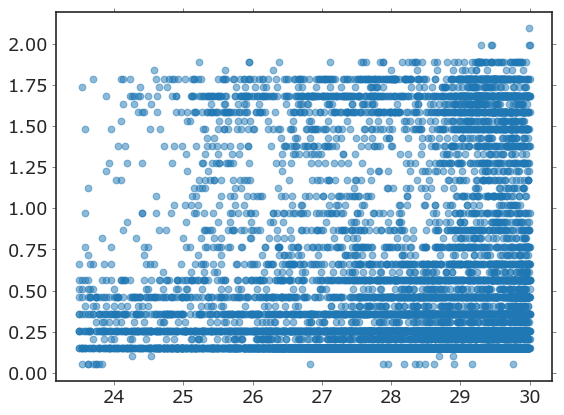

In [13]:
fig, ax=plt.subplots()
mask=np.logical_and(df.bw==0.8, df.rgc=='10_20')
plt.scatter(df.dmod[mask], df.offset_center[mask], alpha=0.5)
#plt.scatter(df.dmod[mask], (df.stream_dens-df.gap_dens)[mask], alpha=1)
#ax.set(yscale='log')

In [14]:
df[np.logical_and.reduce([df.dmod==24.16, df.bw==0.8, df['rgc']=='30_40'])]

,spread_gap_stars_x,spread_gap_stars_y,nstars_gap,nstars_stream,nstars_bck,stream_area,gap_area,bck_area,stream_dens,gap_dens,...,gap_points,stream_center,stream_points,stream_stars,gap_stars,rgc,run,mag_limit,bw,dmod
93,0.510204,0.462013,213.0,1335,527.0,1.44,0.36,2.5,927.083333,591.666667,...,"[34.03061224489796, 34.03061224489796, 34.1326...",35.052632,"[34.8421052631579, 34.94736842105263, 35.05263...","[35.119290260879346, 35.09921956822725, 35.120...","[34.309367780019954, 35.54879232026715, 34.111...",30_40,run06743,28.69,0.8,24.16
5099,0.714286,0.370221,244.0,1328,553.0,1.44,0.36,2.5,922.222222,677.777778,...,"[34.03061224489796, 34.03061224489796, 34.1326...",35.052632,"[34.8421052631579, 34.94736842105263, 35.05263...","[35.16248160705758, 35.09920961099401, 35.0112...","[35.63597016900998, 34.29018921946006, 34.2430...",30_40,run06568,28.69,0.8,24.16
22893,0.612245,0.392557,77.0,461,155.0,1.44,0.36,2.5,320.138889,213.888889,...,"[34.234693877551024, 34.234693877551024, 34.33...",35.052632,"[34.8421052631579, 34.94736842105263, 35.05263...","[35.21711776708417, 34.95999229371622, 34.8662...","[34.402582083211485, 34.94731741758039, 34.357...",30_40,run01117,27.15,0.8,24.16
68493,0.510204,0.412594,215.0,1338,519.0,1.44,0.36,2.5,929.166667,597.222222,...,"[34.13265306122449, 34.13265306122449, 34.2346...",35.052632,"[34.8421052631579, 34.94736842105263, 35.05263...","[35.02139195776636, 34.81243953022125, 35.1035...","[34.90237391338309, 34.63106777638737, 35.1619...",30_40,run01952,28.69,0.8,24.16
150449,0.510204,0.403859,233.0,1330,547.0,1.44,0.36,2.5,923.611111,647.222222,...,"[34.13265306122449, 34.13265306122449, 34.2346...",35.052632,"[34.8421052631579, 34.94736842105263, 35.05263...","[35.08649053037761, 35.172517493499974, 35.001...","[34.86301291929548, 34.15578140692055, 34.0930...",30_40,run02802,28.69,0.8,24.16
168243,0.612245,0.329526,265.0,1371,527.0,1.44,0.36,2.5,952.083333,736.111111,...,"[33.92857142857143, 33.92857142857143, 34.0306...",35.052632,"[34.8421052631579, 34.94736842105263, 35.05263...","[35.1112551802868, 35.148882799064516, 34.8793...","[34.66680646837062, 33.94185234034084, 34.7198...",30_40,run06327,28.69,0.8,24.16
200799,0.510204,0.373315,74.0,476,155.0,1.44,0.36,2.5,330.555556,205.555556,...,"[34.234693877551024, 34.234693877551024, 34.33...",35.052632,"[34.8421052631579, 34.94736842105263, 35.05263...","[35.09109498312147, 34.97212341051584, 35.0585...","[34.3179119453514, 35.45486382735114, 35.83323...",30_40,run01776,27.15,0.8,24.16
218849,0.408163,0.463679,73.0,519,154.0,1.44,0.36,2.5,360.416667,202.777778,...,"[34.33673469387755, 34.33673469387755, 34.4387...",35.052632,"[34.8421052631579, 34.94736842105263, 35.05263...","[34.99620803455789, 35.24582687587315, 35.0791...","[35.76032940704528, 34.4160442723266, 35.37876...",30_40,run07919,27.15,0.8,24.16
282499,0.510204,0.320173,66.0,471,150.0,1.44,0.36,2.5,327.083333,183.333333,...,"[34.234693877551024, 34.234693877551024, 34.33...",35.052632,"[34.8421052631579, 34.94736842105263, 35.05263...","[35.21314599178562, 34.95639260117597, 34.9766...","[34.60812435958416, 34.37663947641508, 34.2116...",30_40,run05091,27.15,0.8,24.16
305043,0.714286,0.503897,99.0,452,150.0,1.44,0.36,2.5,313.888889,275.000000,...,"[33.826530612244895, 33.826530612244895, 33.92...",35.052632,"[34.8421052631579, 34.94736842105263, 35.05263...","[35.05855301095584, 35.025068940608286, 34.976...","[34.6257934141596, 33.99588908283568, 33.89120...",30_40,run01142,27.15,0.8,24.16


In [15]:
len(np.unique(df.dmod)), np.unique(df.bw)

(500,
 array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
        1.4, 1.5, 1.6, 1.7, 1.8, 1.9]))

In [16]:
np.unique(df.dmod)

array([23.49, 23.54, 23.58, 23.62, 23.66, 23.7 , 23.74, 23.78, 23.82,
       23.85, 23.89, 23.93, 23.96, 24.  , 24.03, 24.06, 24.1 , 24.13,
       24.16, 24.19, 24.23, 24.26, 24.29, 24.32, 24.35, 24.38, 24.4 ,
       24.43, 24.46, 24.49, 24.52, 24.54, 24.57, 24.6 , 24.62, 24.65,
       24.67, 24.7 , 24.72, 24.75, 24.77, 24.8 , 24.82, 24.84, 24.87,
       24.89, 24.91, 24.93, 24.96, 24.98, 25.  , 25.02, 25.04, 25.06,
       25.09, 25.11, 25.13, 25.15, 25.17, 25.19, 25.21, 25.23, 25.25,
       25.27, 25.28, 25.3 , 25.32, 25.34, 25.36, 25.38, 25.4 , 25.41,
       25.43, 25.45, 25.47, 25.48, 25.5 , 25.52, 25.54, 25.55, 25.57,
       25.59, 25.6 , 25.62, 25.64, 25.65, 25.67, 25.68, 25.7 , 25.72,
       25.73, 25.75, 25.76, 25.78, 25.79, 25.81, 25.82, 25.84, 25.85,
       25.87, 25.88, 25.89, 25.91, 25.92, 25.94, 25.95, 25.97, 25.98,
       25.99, 26.01, 26.02, 26.03, 26.05, 26.06, 26.07, 26.09, 26.1 ,
       26.11, 26.13, 26.14, 26.15, 26.16, 26.18, 26.19, 26.2 , 26.22,
       26.23, 26.24,

In [82]:
1e-3*(10**((24.52/5)+1))

801.678063387679

In [64]:
dmods2=[ 24.52,  25.  , 25.88, 26.51, 27.5, 28.5 ]

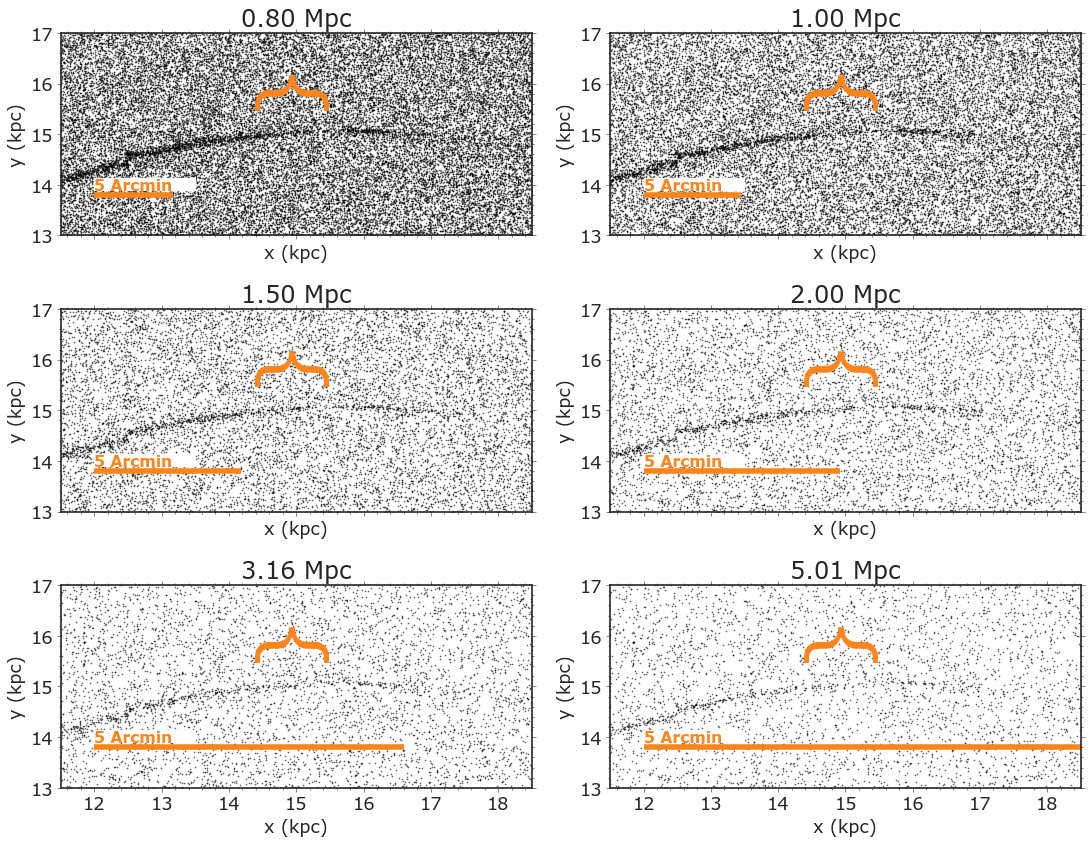

In [73]:
fig, ax=plt.subplots(nrows=3, ncols=2, figsize=(14, 10.9), sharex=True, sharey=False)
rgc='10_20'
rgcx=15
xlim=[rgcx-3.5, rgcx+3.5]
ylim=[rgcx-2, rgcx+2]

bw=0.7

axs= np.concatenate(ax)
for idx in range(len(axs)):
    a=axs[idx]
    dmod=dmods2[idx]
    #print (dmod)
    #print (rgc)
    #print (bw)
    
    res=np.random.choice(get_pipeline_results_full(dmod, 28.69, rgc, bwu=bw))
    #print (res)
    #_=show_gap_detection(res,  plot='plot3', ax=a)
    dmod=float(dmod)
    #print(dmod)
    a.scatter(res['data'][0], res['data'][1], s=.1, c='k', alpha=1)
    #a.hist2d(res['data'][0], res['data'][1], bins=int(28*1.5), range=[xlim, ylim], cmap='Greys')
    a.minorticks_on()
    #a.axis('equal')
    
    d_galaxy=(1e-3*(10**((dmod/5)+1)))*u.kpc
    kpc_conversion = np.pi * d_galaxy / 180.
    roman_fov= 0.52*u.degree*(kpc_conversion /u.degree)
    scaled_arcmin= 5*u.arcmin.to(u.degree)*(kpc_conversion /u.degree).value
    
    a.hlines(y=rgcx-1.2, xmin= rgcx-3, xmax=rgcx-3+scaled_arcmin, \
             linewidth=5,  color='#FF851B')
    
    rect = patches.Rectangle( (rgcx-3, rgcx-1.1), \
                               1.5, 0.24, linewidth=1, edgecolor='w', facecolor='w')
    a.add_patch(rect)
    a.text(rgcx-3, rgcx-1.1, '5 Arcmin',\
           color='#FF851B', alpha=1, fontsize=14, weight='bold')
    
    a.text(rgcx-0.7,  rgcx+0.5, u'\u007d', fontsize=70, ha='left', va='bottom', rotation=90,  color='#FF851B')
    #a.scatter(34.5,  35.0+0.3, color='#0074D9', marker='$\u2193$', s=600)
    
    

    a.set(title='{:.2f} Mpc'.format(1e-6*(10**((dmod/5)+1))), xlabel='x (kpc)', ylabel='y (kpc)', 
    xlim=xlim, ylim=ylim)

plt.tight_layout()
plt.savefig('../figures/gaps_visual_detections{}.jpeg'.format(rgc))

In [74]:
'gaps_visual_detections{}.jpeg'.format(rgc)

'gaps_visual_detections10_20.jpeg'

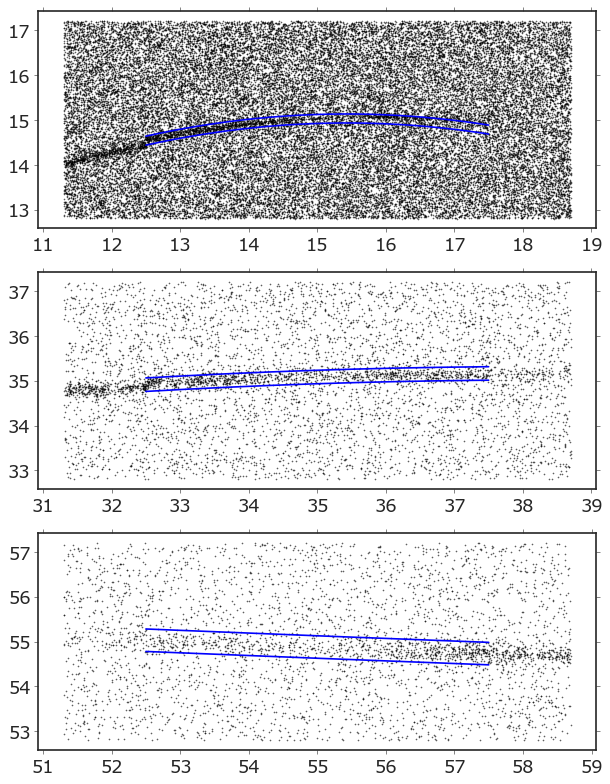

In [21]:
fig,ax=plt.subplots(nrows=3, figsize=(6*1.5, 8*1.5))
#PATH_POLYNOMIALS[]
bw=0.6
dmod=24.52
for idx in range(0, 3):
    rgc=['10_20', '30_40', '50_60'][idx]
    
    res=get_pipeline_results_full(dmod, 28.69, rgc, bwu=bw)[0]
    dt=res['data']
    
    stream_size=THEORITICAL_STREAM_WIDTHS[rgc]

    ax[idx].scatter(dt[0], dt[1], s=0.1, c='k')
    
    ax[idx].plot(res['grid_data'][:,0], PATH_POLYNOMIALS[rgc](res['grid_data'][:,0])-stream_size/2, c='b')
    ax[idx].plot(res['grid_data'][:,0], PATH_POLYNOMIALS[rgc](res['grid_data'][:,0])+stream_size/2, c='b')
    


In [22]:
#rgc='50_60'
#3*THEORITICAL_STREAM_WIDTHS[rgc]

In [23]:
#3*THEORITICAL_STREAM_WIDTHS[rgc]

In [24]:
def plot_grid_lines(x, y, ax):
    # Plot the vertical grid lines
    for i in range(len(x)):
        ax.plot([x[i], x[i]], [y[0], y[-1]], 'k-', alpha=0.1,  linewidth=0.05)

    # Plot the horizontal grid lines
    for i in range(len(y)):
        ax.plot([x[0], x[-1]], [y[i], y[i]], 'k-', alpha=0.1,  linewidth=0.05)



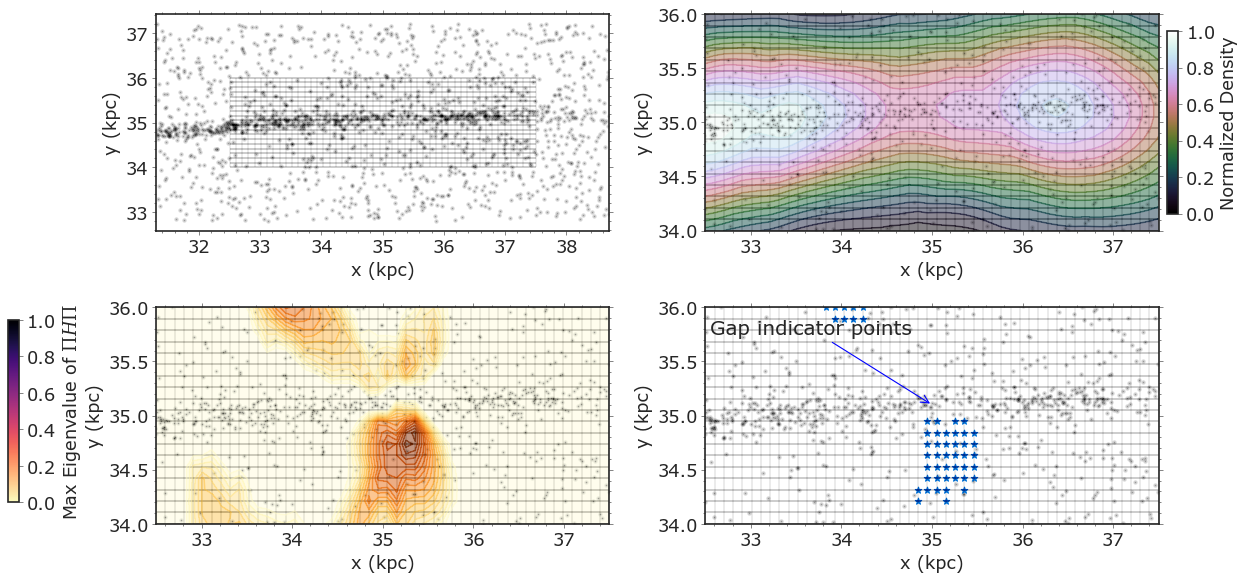

In [141]:
fig, ax=plt.subplots(nrows=2, ncols=2, figsize= (7*2, 4*1.9))
dmod= 24.52
rgc='30_40'
bw=0.6
rgcx=35
res=np.random.choice(get_pipeline_results_full( dmod, 27.15, rgc, bwu=bw))
#resx= np.load('../data/test.npy', allow_pickle=True).flatten()[0]
#res=resx[list(resx.keys())[0]]
#print (resx)
dt=res['data']
vld=res
gap_mask = vld['max_eigen'] > np.percentile(vld['max_eigen'].flatten(),GAP_PERCENTILE ) 

grid_data=res['grid_data']
for a in np.concatenate(ax):
    a.scatter(dt[0], dt[1], s=10, alpha=0.1, c='k')
    a.set(xlim=[dt[0].min(), dt[0].max()], xlabel='x (kpc)', ylabel='y (kpc)')
    a.minorticks_on()
    plot_grid_lines(grid_data[:,0], grid_data[:,1], a)
    
ax[0][0].scatter(dt[0], dt[1], s=.1, alpha=0.5, c='k')
ax[-1][-1].scatter(dt[0], dt[1], s=.1, alpha=0.5, c='k')

ax[0][1].contour(res['meshgrid'][0], res['meshgrid'][1],  res['density'],  20, \
                              cmap='cubehelix', alpha=0.5, linestyle='--')
ax[0][1].contourf(res['meshgrid'][0], res['meshgrid'][1],  res['density'],  20, \
                              cmap='cubehelix', alpha=0.5, linestyle='--')


ax[1][0].contour(res['meshgrid'][0], res['meshgrid'][1],  res['max_eigen'],  20, \
                              cmap='YlOrBr', alpha=0.5, linestyle='--')
ax[1][0].contourf(res['meshgrid'][0], res['meshgrid'][1],  res['max_eigen'],  20, \
                              cmap='YlOrBr', alpha=0.5, linestyle='--')



#ax[1][1].contour(res['meshgrid'][0], res['meshgrid'][1],  res['min_eigen'],  20, \
#                              cmap='YlOrBr', alpha=0.5, linestyle='--')
#ax[1][1].contourf(res['meshgrid'][0], res['meshgrid'][1],  res['min_eigen'],  20, \
#                              cmap='YlOrBr', alpha=0.5, linestyle='--')

pol=PATH_POLYNOMIALS[rgc]
stream_size=  5*THEORITICAL_STREAM_WIDTHS[rgc]
#ax[1][-1].plot(vld['meshgrid'][0], pol(vld['meshgrid'][0])+stream_size/2, color='#FF851B', linewidth=1)
#ax[1][-1].plot(vld['meshgrid'][0], pol(vld['meshgrid'][0])-stream_size/2, c='#FF851B', linewidth=1)



ax[1][-1].scatter(vld['meshgrid'][0][gap_mask], vld['meshgrid'][1][gap_mask], marker='*', color='#0074D9')

ax[0][1].scatter(dt[0], dt[1], s=.1, alpha=0.5, c='k')
ax[1][0].scatter(dt[0], dt[1], s=.1, alpha=0.5, c='k')

xlim=[rgcx-2.5, rgcx+2.5]
ylim=[rgcx-1, rgcx+1]
ax[-1][-1].set(xlim=xlim, ylim=ylim)
ax[-1][0].set(xlim=xlim, ylim=ylim)
ax[0][1].set(xlim=xlim, ylim=ylim)
cmap = mpl.cm.magma_r
norm = mpl.colors.Normalize(vmin=0, vmax=1)
cax = fig.add_axes([-0.05, 0.15, 0.01, 0.3])
cax.yaxis.set_ticks_position('left')
cax.yaxis.set_label_position('left')
cax.yaxis.tick_right()
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
            cax=cax, orientation='vertical', label=r'Max Eigenvalue of $\Pi H \Pi$')


cmap = mpl.cm.cubehelix
norm = mpl.colors.Normalize(vmin=0, vmax=1)
cax = fig.add_axes([0.985, 0.625, 0.01, 0.3])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=cax, orientation='vertical', label=r'Normalized Density')
plt.tight_layout()
#plt.savefig('../figures/including_more_data_example.jpeg')
# Add the text annotation with an arrow
ax[1][-1].annotate('Gap indicator points', xy=(rgcx, rgcx+0.1), xytext=(rgcx-2.45, rgcx+.75),
            arrowprops=dict(arrowstyle='->', color='b'))



plt.savefig('../figures/stream_cutout.jpeg', bbox_inches='tight')


In [26]:
colors={'10_20': '#0074D9',
       '30_40': '#111111', 
       '50_60': '#FF851B' }

In [27]:
df['distance']=10**((df.dmod.values/5)+1)

In [28]:
BEST_BW=0.6

In [29]:
vls.keys()

dict_keys(['bw1.9dmod_galaxy30.00'])

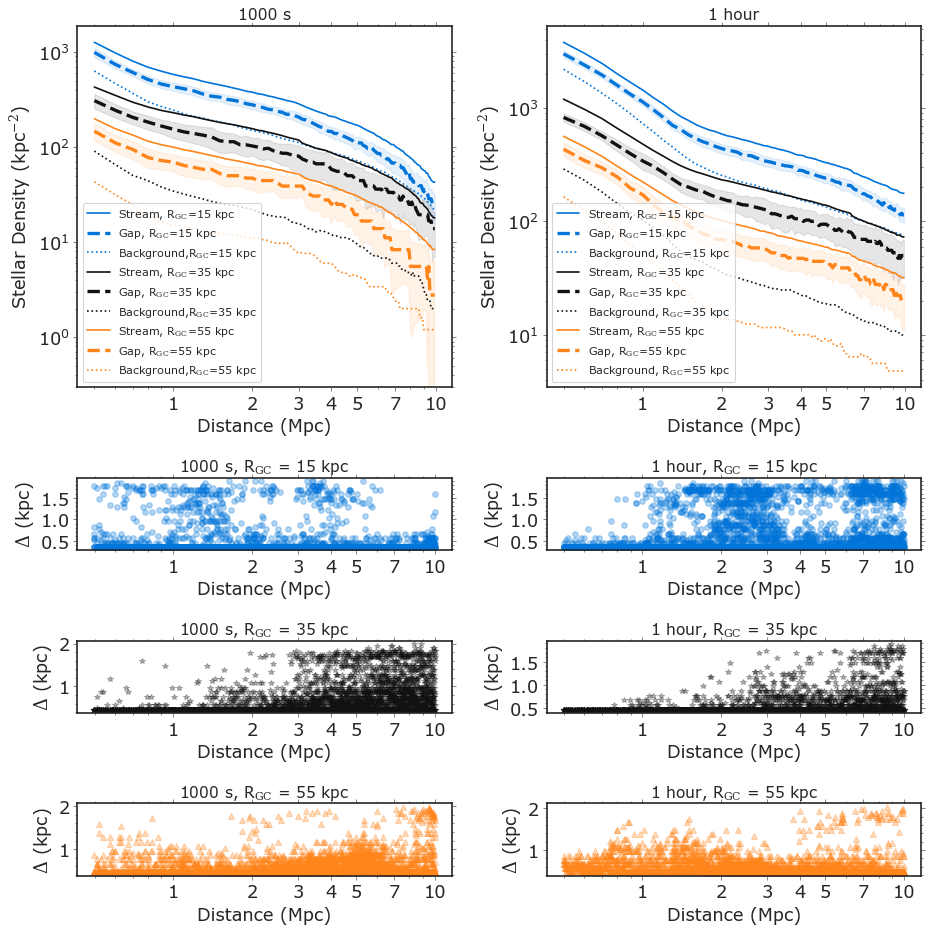

In [47]:
fig, ax=plt.subplots(figsize=(12, 12), ncols=2, nrows=4,  gridspec_kw={'height_ratios': [5, 1, 1, 1]})

for rgc in ['10_20', '30_40', '50_60']:
    
    vls=get_counts(df, dgrid,rgc, 27.15)
  
    rgcx=int(np.nanmedian(np.array(rgc.split('_')).astype(float)))

    make_line_plot( ax[0][0], dgrid[:-1], np.vstack(vls['stream_dens'])[:,0], np.vstack(vls['stream_dens'])[:,1],\
                   rgc, color=colors[rgc], show_error=False, linestyle='-', label=r'Stream, R$_{\rm GC}$'+'={} kpc'.format(rgcx))
    
    make_line_plot( ax[0][0], dgrid[:-1], np.vstack(vls['gap_dens'])[:,0], np.vstack(vls['gap_dens'])[:,1],\
                   rgc, color=colors[rgc], show_error=True, linestyle='--', label=r'Gap, R$_{\rm GC}$'+'={} kpc'.format(rgcx), linewidth=3)
    
    make_line_plot( ax[0][0], dgrid[:-1], np.vstack(vls['bck_dens'])[:,0], np.vstack(vls['bck_dens'])[:,1],\
                   rgc, color=colors[rgc],  show_error=False, linestyle=':', label=r'Background,R$_{\rm GC}$'+'={} kpc'.format(rgcx))
    
  
   
  
    vls=get_counts(df, dgrid,rgc, 28.69)
  
    rgcx=int(np.nanmedian(np.array(rgc.split('_')).astype(float)))

    make_line_plot( ax[0][1], dgrid[:-1], np.vstack(vls['stream_dens'])[:,0], np.vstack(vls['stream_dens'])[:,1],\
                   rgc, color=colors[rgc], show_error=False, linestyle='-', label=r'Stream, R$_{\rm GC}$'+'={} kpc'.format(rgcx))

    make_line_plot( ax[0][1], dgrid[:-1], np.vstack(vls['gap_dens'])[:,0], np.vstack(vls['gap_dens'])[:,1],\
                   rgc, color=colors[rgc], show_error=True, linestyle='--',label=r'Gap, R$_{\rm GC}$'+'={} kpc'.format(rgcx), linewidth=3)
    
    make_line_plot( ax[0][1], dgrid[:-1], np.vstack(vls['bck_dens'])[:,0], np.vstack(vls['bck_dens'])[:,1],\
                   rgc, color=colors[rgc],  show_error=False,linestyle=':', label=r'Background, R$_{\rm GC}$'+'={} kpc'.format(rgcx))
    
    
 
#a.set( xlabel='Distance Modulus', ylabel='Bandwidth (kpc)', ylim=[0.05, 1.65], xlim=[23.7, 29.35])
rgcs=['10_20', '30_40', '50_60']

for idx in range(0,3):
    rgc=rgcs[idx]
    plot_stream_center(ax[1+idx][1], rgc, 28.69 )
    plot_stream_center(ax[1+idx][0], rgc, 27.15)
    rgcx=int(np.nanmedian(np.array(rgc.split('_')).astype(float)))
    a=ax[idx+1]
    a[0].set_title(r'1000 s, R$_{\rm GC}$'+' = {:.0f} kpc'.format(rgcx),fontsize=14)
    a[1].set_title(r'1 hour, R$_{\rm GC}$'+' = {:.0f} kpc'.format(rgcx),fontsize=14)
    #a[0].set(ylim=[0.0, 1.])

for a in np.concatenate(ax):
    a.minorticks_on()
    a.set(xscale='log',  xticks=[1, 2, 3, 4, 5, 7, 10],xticklabels=[1, 2, 3, 4, 5, 7, 10], xlabel='Distance (Mpc)')

for a in ax[0]:
    a.legend(fontsize=10, loc='lower left')
    #a.set(yticks=10**np.array([-1., 0, 1., 2, 2., 3, 4]))
    a.yaxis.set_tick_params(labelbottom=True)
    a.set(ylabel='Stellar Density (kpc$^{-2}$)', yscale='log')
    

ax[0][1].set_title('1 hour'.format(rgcx),fontsize=14)
ax[0][0].set_title('1000 s'.format(rgcx),fontsize=14)


for a in np.concatenate([ax[1], ax[2], ax[3]]):
    #a.set(yscale='log')
    #a.legend(fontsize=10)
    #a.axhline(0.2, linestyle='-', color='k', alpha=0.5, linewidth=3)
    #a.axhline(1, linestyle='-', color='k', alpha=0.5, linewidth=3)
    #a.axhline(0.25, linestyle='-', color='k', alpha=0.5, linewidth=3)
    
    # a.axhline(GAP_SIZE, linestyle='--', color='k', alpha=0.5, linewidth=3)
    #a.axhline(GAP_SIZE/2, linestyle='--', color='k', alpha=0.5, linewidth=3)
    #a.text(1, GAP_SIZE+0.05, 'Gap Size', fontsize=14)
    #a.text(1, GAP_SIZE/2+0.05, 'Gap Size/2', fontsize=14)
    

    plt.setp(a.get_xticklabels(), visible=True)
    
    a.yaxis.set_tick_params(labelbottom=True)
    
    _= a.set(ylabel=r'$\Delta$ (kpc)'.format(rgcx))#, ylim=[-0.5, 2.5])



#ax[1][0].set(ylim=[-2, 2])
#ax[1][1].set(ylim=[-2, 2])
plt.tight_layout()

plt.savefig('../figures/gap_density_errors.pdf')

In [31]:
df['rgcx']=df.rgc.apply(lambda x: np.nanmedian(np.array(x.split('_')).astype(float)))

In [32]:
df['spread_gap_xy']=(df.spread_gap_stars_x**2+df.spread_gap_stars_y**2)**0.5

In [33]:
df.columns

Index(['spread_gap_stars_x', 'spread_gap_stars_y', 'nstars_gap',
       'nstars_stream', 'nstars_bck', 'stream_area', 'gap_area', 'bck_area',
       'stream_dens', 'gap_dens', 'bck_dens', 'offset_center', 'gap_center',
       'gap_points', 'stream_center', 'stream_points', 'stream_stars',
       'gap_stars', 'rgc', 'run', 'mag_limit', 'bw', 'dmod', 'distance',
       'rgcx', 'spread_gap_xy'],
      dtype='object')

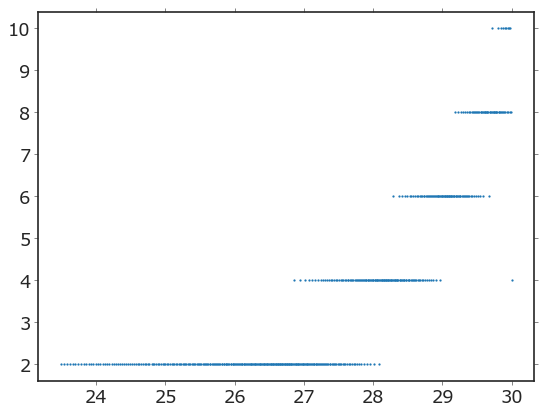

In [34]:
fig, ax=plt.subplots()
dfnx00=df[np.logical_and.reduce([df.mag_limit==28.69, df.bw==0.3, df.rgc=='10_20'])]

nstuff=[]
for g in dfnx00.groupby('dmod'):
    nstuff.append([g[0], len(g[1])])

nstuff=np.vstack(nstuff)
plt.scatter(nstuff[:,0], nstuff[:,1], s=1)

In [35]:
df['deltasigma']=df.offset_center+df.spread_gap_stars_x

In [44]:
df0=df[np.logical_and(df.rgc=='30_40' , df.mag_limit==27.15)]

In [119]:
len(df)

538650

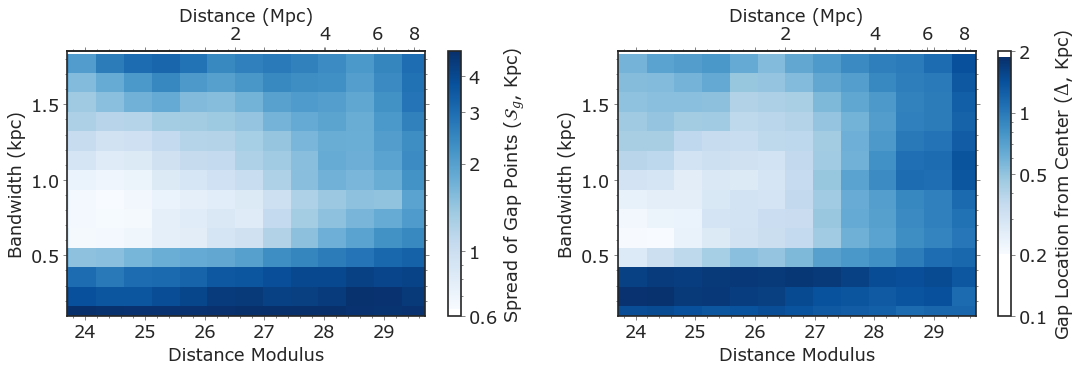

In [45]:
fig, ax=plt.subplots(ncols=2, figsize=(14, 5))

cmap = mpl.cm.Blues
norm1 =mpl.colors.LogNorm()
norm2 =mpl.colors.LogNorm()

plot_annotated_heatmap(ax[0], df0, 15, ['dmod', 'bw', 'spread_gap_stars_x'], norm=norm1,  cmap=cmap,annotate=False, alpha=1)
plot_annotated_heatmap(ax[1], df0, 15, ['dmod', 'bw', 'offset_center'],  norm=norm2, cmap=cmap,annotate=False, alpha=1)
#plot_annotated_heatmap(ax[-1], df0, 15, ['dmod', 'bw', 'deltasigma'],  norm=norm2, cmap=cmap,annotate=False, alpha=0.5)

#ax[0].scatter(df0.dmod, df0.bw, c=df0.spread_gap_stars_x, s=150, marker='*', norm=norm1, cmap=cmap, alpha=0.5)
#c=ax[1].scatter(df0.dmod, df0.bw, c=df0.offset_center, s=150, marker='*', norm=norm1, cmap=cmap, alpha=0.5)



xticks=[0.6, 1, 2, 3, 4]
cbar=plt.colorbar(mpl.cm.ScalarMappable(norm=norm1, cmap=cmap), ax=ax[0], orientation='vertical', label=r'Spread of Gap Points ($\mathcal{S}_g$, Kpc)')
cbar.ax.set_yticks([])
cbar.ax.set_yticklabels([])
cbar.ax.set(yticks=xticks, yticklabels=xticks)


xticks=[0.1,0.2,  0.5, 1, 2]
# Add colorbar, make sure to specify tick locations to match desired ticklabels
#cbar = fig.colorbar(cax, ticks=[-1, 0, 1]) #setting which ticks you actually want
#cbar.ax.set_yticklabels(['< -1', '0', '> 1'])  #satting the labels for those ticks
cbar=plt.colorbar(mpl.cm.ScalarMappable(norm=norm2, cmap=cmap), ax=ax[1], orientation='vertical', label=r'Gap Location from Center ($\Delta$, Kpc)')
cbar.ax.set(yticks=xticks, yticklabels=xticks)

def forward(x):
    return (10**((x/5)+1))/1e6

def inverse(x):
    return  5*np.log10(x*1000/(10))

for a in ax:
    secax = a.secondary_xaxis('top', functions=(forward, inverse))
    secax.set(xlabel='Distance (Mpc)')
    
    a.set( xlabel='Distance Modulus', yticks=[0.5, 1, 1.5, 2.],
          ylabel='Bandwidth (kpc)', ylim=[0.1, 1.85], xlim=[23.7, 29.7])


plt.tight_layout()


#actually make 3 stacks, get rid of first panel to emphasize that best bw doesn't depend on gap size
plt.savefig('../figures/gaps_spread_all_bws.pdf', bbox_inches='tight')


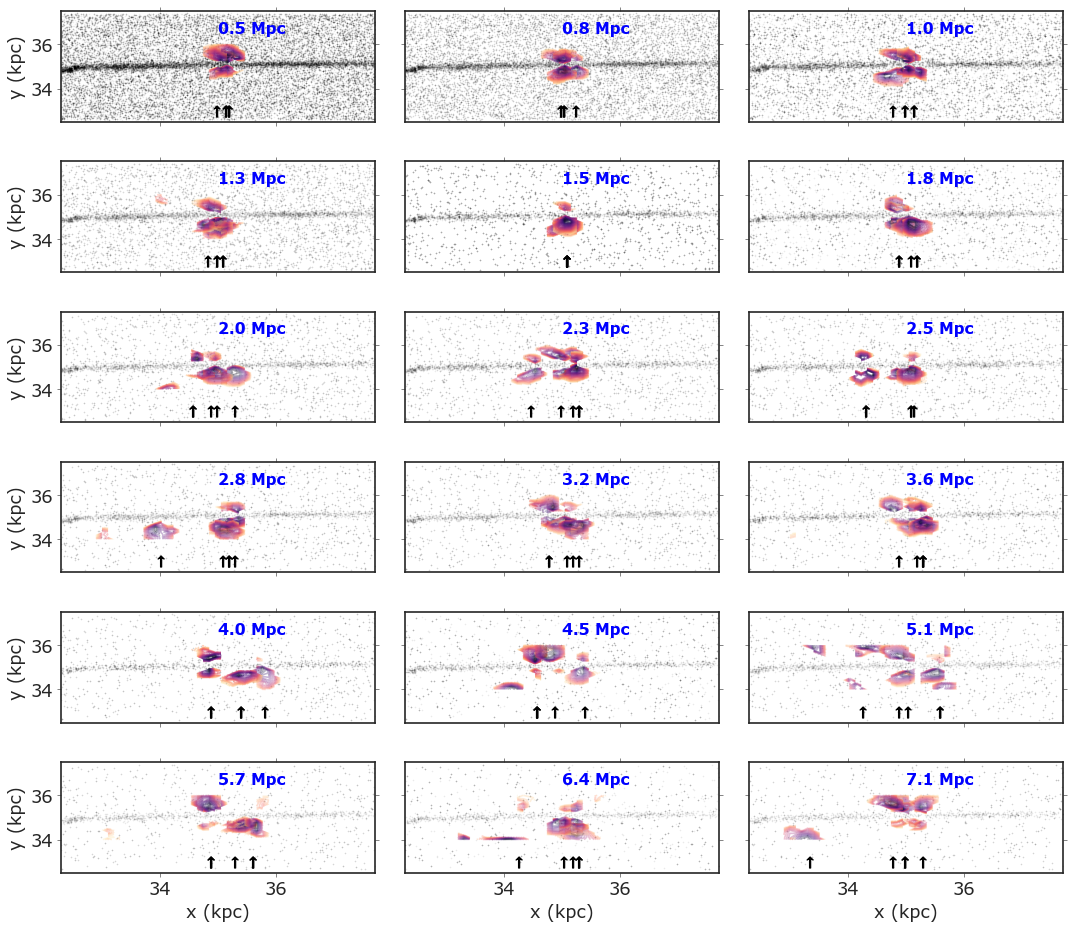

In [133]:
dmods=np.unique(df.dmod.values[np.logical_and(df.distance/1e6 <=10, df.distance/1e6 > 0.5) ])
dmods=(dmods[::25])
#print (len(dmods))
#i
rgc='30_40'
rgcx=35

fig, ax=plt.subplots(ncols=3, nrows=int(len(dmods)/3), sharey=True, sharex=True, figsize=(14, 2*int(len(dmods)/3)))

axs= np.concatenate(ax)
for idx in range(len(axs)):
    a=axs[idx]
    dmod=dmods[idx]
    
    #resx0=np.random.choice(get_pipeline_results_full(dmod, 28.69, rgc, bwu=0.8), 10)
    resx1=np.random.choice(get_pipeline_results_full(dmod, 28.69, rgc, bwu=0.7), 5)
    #resx2=np.random.choice(get_pipeline_results_full(dmod, 28.69, rgc, bwu=0.6), 10)
    
    #resx=np.concatenate([resx0, resx1, resx2])
    resx=resx1
    meds=[]
    #print (len(resx1))
    for res in resx:
        plotres=show_gap_detection(res, GAP_SIZES[rgc])
        mask= res['max_eigen']>  np.percentile(res['max_eigen'].flatten(), GAP_PERCENTILE) 
        Z_masked = np.ma.masked_array(res['max_eigen'], ~mask)
        p= a.contour(res['meshgrid'][0], res['meshgrid'][1],  Z_masked,  20, \
                                  cmap='magma_r', alpha=.3, linestyle='--')
        meds.append(np.nanmedian(plotres['gap_points']))
        
        dt=res['data']
        a.scatter(dt[0], dt[1], s=0.1, alpha=0.1*dmod/(dmods[0]), c='k')

    for m in meds:
        a.scatter(m, rgcx-2, color='k', marker='$\u2191$', s=100, zorder=10)


    
    rect = patches.Rectangle( (rgcx,rgcx+1.5), \
                               2, 0.3, linewidth=1, edgecolor='#FFFFFF', facecolor='#FFFFFF')
    #a.add_patch(rect)
    title='{:.1f} Mpc'.format(1e-6*(10**((dmod/5)+1)))
    a.text(rgcx, rgcx+1.5, title,\
           color='b', alpha=1, fontsize=14, weight='bold')
    xlim=[rgcx-2.7, rgcx+2.7]
    ylim=[rgcx-2.5, rgcx+2.5]
    a.set( xlim=xlim, ylim=ylim)
    
    
    del resx
    
for a in np.array(ax)[:,0]:
    a.set(ylabel='y (kpc)')
    
for a in np.vstack(ax).T:
    a[-1].set(xlabel='x (kpc)')
    
#ax.scatter(res['meshgrid'][0], res['meshgrid'][1], marker='+', alpha=0.1)
plt.tight_layout()
plt.savefig('../figures/visual_detections_rgc35.jpeg')


In [ ]:
#consider averaging bw=0.6 and 0.9 for last figure of densities and see if this makes a difference--> good to try

In [ ]:
#DRTFYGHUJIK

In [ ]:
#plt.style.use('dark_background') #for posters

In [ ]:
resxs=np.load('../data/appendix_intact.npy', allow_pickle=True).flatten()


for idx in range(len(resxs)):
    resx=resxs[idx]
    ks= [k for k in resx.keys()]
    res=resx[ks[0]]
    print (idx, ks[0])

    #_= show_gap_detection(res,  GAP_SIZES[rgc], plot='density', ax=ax[idx][0], alpha=0.3)
    dt=res['data']
    fig, ax=plt.subplots(ncols=4, figsize= (16, 3))
    
    ax[0].scatter(dt[0], dt[1], s=0.1, alpha=0.5,c='k')

    ax[1].contour(res['meshgrid'][0], res['meshgrid'][1],  res['density'],  20, \
                                  cmap='cubehelix', alpha=0.5, linestyle='--')
    ax[1].contourf(res['meshgrid'][0], res['meshgrid'][1],  res['density'],  20, \
                                  cmap='cubehelix', alpha=0.5, linestyle='--')


    ax[2].contour(res['meshgrid'][0], res['meshgrid'][1],  res['max_eigen'],  20, \
                                  cmap='YlOrBr', alpha=0.5, linestyle='--')
    ax[2].contourf(res['meshgrid'][0], res['meshgrid'][1],  res['max_eigen'],  20, \
                                  cmap='YlOrBr', alpha=0.5, linestyle='--')

    bw=(ks[0].split('dmod')[0]).split('bw')[-1]
    #a.set(title='Bandwidth={} kpc'.format(bw))
    #ax[idx][1].set(title='Bandwidth={} kpc'.format(bw))
    
    pol=PATH_POLYNOMIALS[rgc]
    
    grid_data=res['grid_data']
    
    dt=res['data']
    vld=res
    gap_mask = vld['max_eigen'] > np.percentile(vld['max_eigen'].flatten(),GAP_PERCENTILE ) 

    ax[-1].scatter(vld['meshgrid'][0][gap_mask], vld['meshgrid'][1][gap_mask], marker='*', color='#0074D9')
    ax[-1].scatter(dt[0], dt[1], s=.1, alpha=0.5, c='k')
    
    
    cmap = mpl.cm.YlOrBr
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    cax = fig.add_axes([0.566, -0.05, 0.165, 0.05])
    fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                 cax=cax, orientation='horizontal', label=r'Max Eigenvalue of $\Pi H \Pi$')

    cmap = mpl.cm.cubehelix
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    cax = fig.add_axes([0.32, -0.05, 0.165, 0.05])
    fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                 cax=cax, orientation='horizontal', label=r'Density')



    for a in ax:
        a.scatter(dt[0], dt[1], s=.1, alpha=0.1, c='k')
        #a.set(xlim=[grid_data[0:,].min(), grid_data[:,0].max()], xlabel='x (kpc)', ylabel='y (kpc)')
        #a.set(ylim=[grid_data[1:,].min(), grid_data[:,1].max()])
        a.set(xlabel='x (kpc)', ylabel='y (kpc)')#, xlim=[35-2.5, 35+2.5], ylim=[35-1, 35+1])
        a.minorticks_on()

    plt.tight_layout()
    plt.savefig('../figures/appendix_unpeturbed{}.jpeg'.format(int(idx)), bbox_inches='tight')

In [ ]:
resxs=np.load('../data/appendix_offcenter.npy', allow_pickle=True).flatten()


for idx in range(len(resxs)):
    resx=resxs[idx]
    ks= [k for k in resx.keys()]
    print (idx, ks[0])
    res=resx[ks[0]]

    #_= show_gap_detection(res,  GAP_SIZES[rgc], plot='density', ax=ax[idx][0], alpha=0.3)
    dt=res['data']
    fig, ax=plt.subplots(ncols=4, figsize= (16, 3))
    ax[0].scatter(dt[0], dt[1], s=0.1, alpha=0.5, c='k')

    ax[1].contour(res['meshgrid'][0], res['meshgrid'][1],  res['density'],  20, \
                                  cmap='cubehelix', alpha=0.5, linestyle='--')
    ax[1].contourf(res['meshgrid'][0], res['meshgrid'][1],  res['density'],  20, \
                                  cmap='cubehelix', alpha=0.5, linestyle='--')


    ax[2].contour(res['meshgrid'][0], res['meshgrid'][1],  res['max_eigen'],  20, \
                                  cmap='YlOrBr', alpha=0.5, linestyle='--')
    ax[2].contourf(res['meshgrid'][0], res['meshgrid'][1],  res['max_eigen'],  20, \
                                  cmap='YlOrBr', alpha=0.5, linestyle='--')

    bw=(ks[0].split('dmod')[0]).split('bw')[-1]
    #a.set(title='Bandwidth={} kpc'.format(bw))
    #ax[idx][1].set(title='Bandwidth={} kpc'.format(bw))
    
    pol=PATH_POLYNOMIALS[rgc]
    
    grid_data=res['grid_data']
    
    dt=res['data']
    vld=res
    gap_mask = vld['max_eigen'] > np.percentile(vld['max_eigen'].flatten(),GAP_PERCENTILE ) 


    ax[-1].scatter(vld['meshgrid'][0][gap_mask], vld['meshgrid'][1][gap_mask], marker='*', color='#0074D9')
    ax[-1].scatter(dt[0], dt[1], s=.1, alpha=0.5, c='k')
    
    
    cmap = mpl.cm.YlOrBr
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    cax = fig.add_axes([0.566, -0.05, 0.165, 0.05])
    fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                 cax=cax, orientation='horizontal', label=r'Max Eigenvalue of $\Pi H \Pi$')

    cmap = mpl.cm.cubehelix
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    cax = fig.add_axes([0.32, -0.05, 0.165, 0.05])
    fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                 cax=cax, orientation='horizontal', label=r'Density')



    for a in ax:
        a.scatter(dt[0], dt[1], s=.1, alpha=0.1, c='k')
        #a.set(xlim=[grid_data[0:,].min(), grid_data[:,0].max()], xlabel='x (kpc)', ylabel='y (kpc)')
        #a.set(ylim=[grid_data[1:,].min(), grid_data[:,1].max()])
        a.set(xlabel='x (kpc)', ylabel='y (kpc)')
        a.minorticks_on()

    plt.tight_layout()
    plt.savefig('../figures/appendix_offcenter{}.jpeg'.format(int(idx)),  bbox_inches='tight')

In [ ]:
#all bws only needs to be computed once, then multiple runs for 0.7 or whatevs
#alright looks like we are back to 5 x 2 because 2x1x2+5 = 9

In [ ]:
#np.unique(df.dmod)

In [ ]:
#2*2*2+5

In [120]:
dmod= 29.67
1e-6*(10**((dmod/5)+1))

8.59013521505396

In [113]:
np.unique(df.dmod)

array([23.49, 23.54, 23.58, 23.62, 23.66, 23.7 , 23.74, 23.78, 23.82,
       23.85, 23.89, 23.93, 23.96, 24.  , 24.03, 24.06, 24.1 , 24.13,
       24.16, 24.19, 24.23, 24.26, 24.29, 24.32, 24.35, 24.38, 24.4 ,
       24.43, 24.46, 24.49, 24.52, 24.54, 24.57, 24.6 , 24.62, 24.65,
       24.67, 24.7 , 24.72, 24.75, 24.77, 24.8 , 24.82, 24.84, 24.87,
       24.89, 24.91, 24.93, 24.96, 24.98, 25.  , 25.02, 25.04, 25.06,
       25.09, 25.11, 25.13, 25.15, 25.17, 25.19, 25.21, 25.23, 25.25,
       25.27, 25.28, 25.3 , 25.32, 25.34, 25.36, 25.38, 25.4 , 25.41,
       25.43, 25.45, 25.47, 25.48, 25.5 , 25.52, 25.54, 25.55, 25.57,
       25.59, 25.6 , 25.62, 25.64, 25.65, 25.67, 25.68, 25.7 , 25.72,
       25.73, 25.75, 25.76, 25.78, 25.79, 25.81, 25.82, 25.84, 25.85,
       25.87, 25.88, 25.89, 25.91, 25.92, 25.94, 25.95, 25.97, 25.98,
       25.99, 26.01, 26.02, 26.03, 26.05, 26.06, 26.07, 26.09, 26.1 ,
       26.11, 26.13, 26.14, 26.15, 26.16, 26.18, 26.19, 26.2 , 26.22,
       26.23, 26.24,

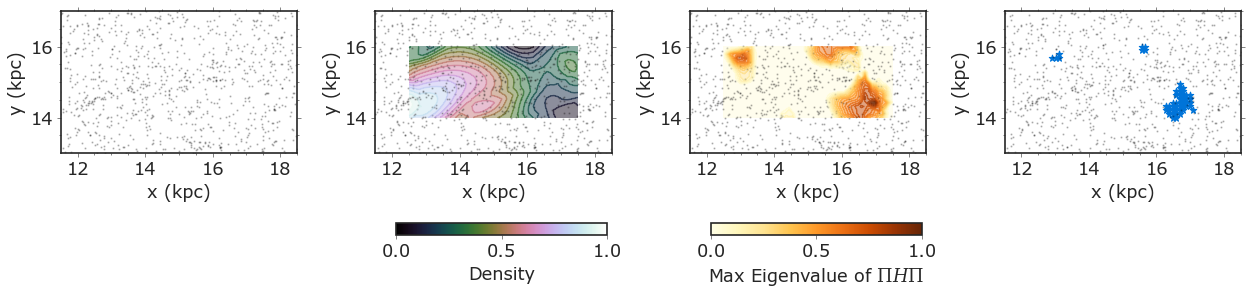

In [125]:
fig, ax=plt.subplots(ncols=4, figsize= (16, 3))
dmod=29.67
rgc='10_20'
rgcx=15
bw=0.8
res=np.random.choice(get_pipeline_results_full( dmod, 27.15, rgc, bwu=bw))
#resx= np.load('../data/test.npy', allow_pickle=True).flatten()[0]
#res=resx[list(resx.keys())[0]]
#print (resx)
dt=res['data']

vld=res
gap_mask = vld['max_eigen'] > np.percentile(vld['max_eigen'].flatten(),GAP_PERCENTILE ) 

#ax[0].scatter(dt[0], dt[1], s=0.1, alpha=0.1, c='k')

ax[1].contour(res['meshgrid'][0], res['meshgrid'][1],  res['density'],  20, \
                              cmap='cubehelix', alpha=0.5, linestyle='--')
ax[1].contourf(res['meshgrid'][0], res['meshgrid'][1],  res['density'],  20, \
                              cmap='cubehelix', alpha=0.5, linestyle='--')


ax[2].contour(res['meshgrid'][0], res['meshgrid'][1],  res['max_eigen'],  20, \
                              cmap='YlOrBr', alpha=0.5, linestyle='--')
ax[2].contourf(res['meshgrid'][0], res['meshgrid'][1],  res['max_eigen'],  20, \
                              cmap='YlOrBr', alpha=0.5, linestyle='--')



#ax[1][1].contour(res['meshgrid'][0], res['meshgrid'][1],  res['min_eigen'],  20, \
#                              cmap='YlOrBr', alpha=0.5, linestyle='--')
#ax[1][1].contourf(res['meshgrid'][0], res['meshgrid'][1],  res['min_eigen'],  20, \
#                              cmap='YlOrBr', alpha=0.5, linestyle='--')

pol=PATH_POLYNOMIALS[rgc]
#ax[-1].plot(vld['meshgrid'][0], pol(vld['meshgrid'][0])+stream_size/2, color='#FF851B', linewidth=3)
#ax[-1].plot(vld['meshgrid'][0], pol(vld['meshgrid'][0])-stream_size/2, c='#FF851B', linewidth=3)

grid_data=res['grid_data']

ax[-1].scatter(vld['meshgrid'][0][gap_mask], vld['meshgrid'][1][gap_mask], marker='*', color='#0074D9')

for a in ax:
    a.scatter(dt[0], dt[1], s=1, alpha=0.2, c='k')
    #a.set(xlim=[dt[0].min()+1, dt[0].max()-1])
    #a.set(ylim=[dt[1].min()+1.5, dt[1].max()-1.5])
    a.set(xlim=[rgcx-3.5, rgcx+3.5], ylim=[rgcx-2, rgcx+2])
    a.set(xlabel='x (kpc)', ylabel='y (kpc)')
    a.minorticks_on()


cmap = mpl.cm.YlOrBr
norm = mpl.colors.Normalize(vmin=0, vmax=1)
cax = fig.add_axes([0.566, -0.05, 0.165, 0.05])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=cax, orientation='horizontal', label=r'Max Eigenvalue of $\Pi H \Pi$')

cmap = mpl.cm.cubehelix
norm = mpl.colors.Normalize(vmin=0, vmax=1)
cax = fig.add_axes([0.32, -0.05, 0.165, 0.05])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=cax, orientation='horizontal', label=r'Density')

plt.tight_layout()
#plt.savefig('../figures/including_more_data_example.jpeg')
plt.savefig('../figures/appendix_failure4.jpeg', bbox_inches='tight')


In [ ]:
dmods=np.unique(df.dmod.values[np.logical_and(df.distance/1e6 <10, df.distance/1e6 > 0.7) ])
dmods=(dmods[::3])
len(dmods)
rgc='30_40'

fig, ax=plt.subplots(ncols=4, nrows=int(len(dmods)/4), figsize=(14, 2*int(len(dmods)/4)))

axs= np.concatenate(ax)
for idx in range(len(axs)):
    a=axs[idx]
    dmod=dmods[idx]
    
    resx=np.random.choice(get_pipeline_results_full(dmod, 27.15, rgc, bwu=0.8), 5)
    meds=[]
    for res in resx:
        plotres=show_gap_detection(res, GAP_SIZES[rgc])
        #p= a.contourf(res['meshgrid'][0], res['meshgrid'][1],  res['density'],  20, \
        #                          cmap='cubehelix', alpha=.1, linestyle='--')
        a.scatter(res['data'][0], res['data'][1], s=0.1, alpha=0.1, c='k')
        meds.append(np.nanmedian(plotres['gap_points']))

    for m in meds:
        a.scatter(m, 34.5, color='k', marker='$\u2191$', s=100, zorder=10)

    
    title='{:.2f} Mpc'.format(1e-6*(10**((dmod/5)+1)))
    
    rect = patches.Rectangle( (35,35.5), \
                               2, 0.3, linewidth=1, edgecolor='#FFFFFF', facecolor='#FFFFFF')
    a.add_patch(rect)
    a.text(35, 35.5, title,\
           color='b', alpha=1, fontsize=14, weight='bold')
    a.set(xlabel='x (kpc)', ylabel='y (kpc)')
    
    del resx
#ax.scatter(res['meshgrid'][0], res['meshgrid'][1], marker='+', alpha=0.1)
plt.tight_layout()
plt.savefig('../figures/visual_detections_rgc35_scatter.jpeg')


In [ ]:
meshgrid=res['meshgrid']

In [ ]:
#maybe don't need to show polynomial fit 

In [ ]:
 np.ptp(meshgrid[0][gap_mask])

In [142]:
(90000*u.lightyear).to(u.kpc)

<Quantity 27.59412544 kpc>

In [ ]:
for d in 

##### 